# Treinamento do Modelo de Inteligência Artificial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import dump, load

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import train_test_split, HalvingGridSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.expand_frame_repr', False)

2024-02-10 23:09:06.379753: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importando o Banco de Dados

O banco de dados importado já passou pelo pré-processamendo no algoritmo anterior e está pronto para ser treinado.

In [2]:
df = pd.read_csv('features_selecionadas.csv')  

print(f'Número de linhas: {df.shape [0]}')
print(f'Número de colunas: {df.shape [1]}')
df

Número de linhas: 48185
Número de colunas: 18


,amp_1,amp_2,pico_3,pico_2,cf_3,cf_1,kurt_1,med_1,med_3,med_2,skew_3,kurt_2,skew_2,skew_1,kf_1,kf_2,kf_3,Classe
0,0.450360,1.055337,0.049626,0.067802,2.767913,2.624840,2.791291,0.008246,0.001066,0.014137,-0.029135,2.548516,-0.182238,-0.031547,42316.398482,1443.041808,921.118189,Classe A
1,0.454219,0.834114,0.061991,0.047890,2.952264,2.884599,2.958243,0.013603,0.013238,0.024208,-0.067801,2.885696,-0.410151,-0.335697,55644.138315,5334.156764,1247.006433,Classe A
2,0.588548,1.107440,0.095776,0.063380,3.017817,2.990037,2.876807,0.007995,-0.002920,-0.001253,-0.062930,2.805858,-0.053052,0.040556,21145.025046,1300.427410,275.839298,Classe A
3,0.438584,0.862590,0.086695,0.049796,3.034847,2.779594,2.925226,0.007647,0.005502,-0.000608,-0.374032,2.551467,0.180873,0.181593,71176.239895,2717.743215,848.124756,Classe A
4,0.437262,1.415784,0.083511,0.067823,3.070142,2.497555,2.337698,0.006942,0.014666,0.011029,0.269110,3.905618,0.237225,0.120808,25909.011862,1804.349871,519.722543,Classe A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48180,0.391527,0.696456,0.072284,0.035199,2.527962,2.539793,2.402830,-0.001322,0.002165,-0.008968,-0.005237,2.434648,0.065264,0.073113,57555.783562,5502.917756,1511.733800,Classe E
48181,0.459876,1.054494,0.053057,0.058119,2.673253,2.847687,2.732346,0.005143,0.002547,-0.004853,0.109302,2.957161,-0.188504,-0.159354,43105.768032,2559.741260,697.290839,Classe E
48182,0.423173,0.859836,0.072374,0.047195,3.367601,2.969554,2.500881,0.007034,0.001714,0.013549,-0.400473,3.332565,0.134941,0.165505,53564.249634,7672.661767,2132.666893,Classe E
48183,0.389736,0.729765,0.057336,0.044845,2.976817,2.508750,2.574379,0.004656,0.001112,0.004551,0.059855,2.855401,0.278691,0.290409,61116.733381,6778.574769,1680.889490,Classe E


# Train-Test Split

Foi separado 20% do bando de dados para testes e 80% para treino.

Em seguida o vetor de target foi convertido para OneHotEncoder, que será utilizado em vários dos métodos a seguir.

Por último as features são deixadas na mesma escala para melhorar o aprendizado de máquina.

In [30]:
# Gerando X e y
df = df.sample(frac=1).reset_index(drop=True) # shuffle
X_cols = df.columns[:-1].to_list()
y_cols = df.columns[-1:].to_list()

X = df[X_cols]
y = df[y_cols]
y_OHE = pd.get_dummies(y).to_numpy(dtype=object) # fazendo o One Hot Encoding da coluna de target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0) # Target OneHotEncoding
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

y_trainOHE = pd.get_dummies(y_train).to_numpy(dtype=float) # One Hot Encoding
y_testOHE = pd.get_dummies(y_test).to_numpy(dtype=float) # One Hot Encoding

sc = StandardScaler()
X_train= sc.fit_transform(X_train)
X_test= sc.transform(X_test)

# Hyper Parameter Tuning

A seguir é feito o Hyper Parameter Tuning de vários modelos de aprendizado de máquinas. São eles:
- Árvore de Decisão
- Random Forest
- SVC
- KNN
- Rede neural

Ao final do programa será rodado o melhor classificador encontrado para cada modelo e comparados lado a lado.

## Árvore de Decisão

O modelo calibrado, junto com a sua acurária, estão mostrado ao final desse notebook junto com todos os outros.

In [32]:
# # Hyper Parameter Tuning Árvore de Decisão
# # O modelo já foi calibrado uma vez e seu resultado está na célula de resultados

# DecisionTree = DecisionTreeClassifier(random_state = 0)
# parameters = {'criterion': ('entropy', 'gini'),
#               'max_depth': [10, 20, 30, 40]}

# clf = GridSearchCV(DecisionTree, parameters)
# clf.fit(X_train, y_train)
# DecisionTree = clf.best_estimator_

# print(DecisionTree)

DecisionTreeClassifier(max_depth=10, random_state=0)


## Random Forest

O modelo calibrado, junto com a sua acurária, estão mostrado ao final desse notebook junto com todos os outros.

In [23]:
# # Hyper Parameter Tuning Random Forest
# # O modelo já foi calibrado uma vez e seu resultado está na célula de resultados

# RandomForest = RandomForestClassifier(random_state = 0)
# parameters = {#'criterion': ('entropy', 'gini'),
#               'max_depth': [10],#, 20, 30, 40],
#               'bootstrap': [False, True]}

# clf = GridSearchCV(RandomForest, parameters)
# clf.fit(X_train, y_train)
# RandomForest = clf.best_estimator_

# print(RandomForest)

RandomForestClassifier(bootstrap=False, max_depth=10, random_state=0)


## Support Vector Classifier

O modelo calibrado, junto com a sua acurária, estão mostrado ao final desse notebook junto com todos os outros.

In [4]:
# # Support Vector Classifier
# # O modelo já foi calibrado uma vez e seu resultado está na célula de resultados

# svc = SVC(random_state = 0)


# parameters = {'kernel': ('linear', 'rbf', 'sigmoid', 'poly'),
#               'decision_function_shape': ['ovo', 'ovr'],
#               'degree': [2, 3],
#               'C': [5, 7, 9, 11]}

# clf = GridSearchCV(svc, parameters)
# clf.fit(X_train, y_train)
# svc = clf.best_estimator_

# print(svc)

SVC(C=5, decision_function_shape='ovo', degree=2, random_state=0)


## K-nearest Neighbours 

O modelo calibrado, junto com a sua acurária, estão mostrado ao final desse notebook junto com todos os outros.

In [24]:
# # KNNeighbours
# # O modelo já foi calibrado uma vez e seu resultado está na célula de resultados

# knn = KNeighborsClassifier()

# parameters = {'n_neighbors': [3, 5, 7, 9, 11],
#               'p': [1, 2, 3]}

# clf = GridSearchCV(knn, parameters)
# clf.fit(X_train, y_train)
# knn = clf.best_estimator_

# print(knn)

KNeighborsClassifier(n_neighbors=11)


## Rede Neural

A seguir será feito a etapa de encontrar o Learning Rate ideal para o modelo

In [53]:
# Rede Neural
def ANN():
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(units=40))
    ann.add(tf.keras.layers.Dense(units=40, activation='relu'))
    ann.add(tf.keras.layers.Dense(units=40))
    ann.add(tf.keras.layers.Dense(units=5, activation='sigmoid'))
    return ann


ann0 = ANN()
ann0.compile(optimizer = 'adam', loss = 'BinaryCrossentropy', metrics = ['accuracy'])


In [58]:
n_epochs = 100
batch_size = 64
funcao = lambda x: 1e-4 * 10**(5 * x/n_epochs)

teste1 = ann0.fit(
                 X_train, y_trainOHE, batch_size = batch_size, epochs = n_epochs,
                 callbacks = [tf.keras.callbacks.LearningRateScheduler( lambda epoch: funcao(epoch) )]
                 )

Epoch 1/100
603/603 [==============================] - 2s 4ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.0000e-04
Epoch 2/100
603/603 [==============================] - 2s 4ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.1220e-04
Epoch 3/100
603/603 [==============================] - 2s 4ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.2589e-04
Epoch 4/100
603/603 [==============================] - 2s 4ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.4125e-04
Epoch 5/100
603/603 [==============================] - 2s 3ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.5849e-04
Epoch 6/100
603/603 [==============================] - 2s 4ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.7783e-04
Epoch 7/100
603/603 [==============================] - 2s 3ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 1.9953e-04
Epoch 8/100
603/603 [==============================] - 2s 3ms/step - loss: 0.5004 - accuracy: 0.2050 - lr: 2.2387e-04
Epoch 9/100
603/603 [==============================] - 2

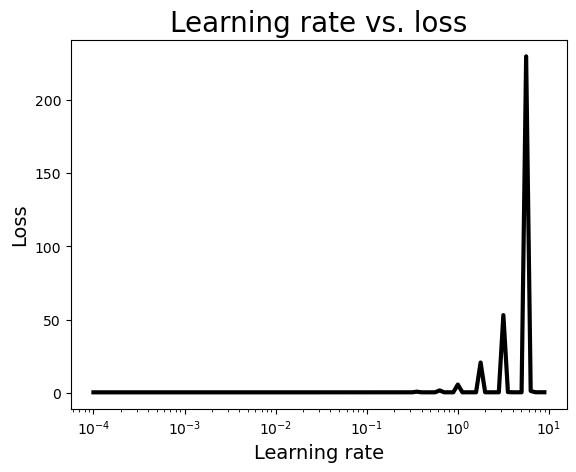


Loss mínimo: 0.5003857612609863
learning rate para mínimo loss: 0.00012589254117941674


In [59]:
learning_rates = funcao(np.arange(n_epochs))
plt.semilogx(learning_rates, teste1.history['loss'], lw=3, color='#000')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14);
plt.show()

teste_loss = np.array(teste1.history['loss'])
min_loss = teste_loss.min()
rate_min = learning_rates[teste_loss == min_loss][0]

print("\nLoss mínimo:", min_loss)
print("learning rate para mínimo loss:", rate_min)

## Treinamento do ANN

Encontrado os parâmetros de calibração para a dada rede, ela será finalmente treinada usando eles como base. 

In [60]:
opt = tf.keras.optimizers.Adam(learning_rate = rate_min)
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

ann = ANN()
ann.compile(optimizer = opt, loss = 'BinaryCrossentropy', metrics = ['accuracy'])

ann.fit(X_train, y_trainOHE, batch_size = batch_size, epochs = n_epochs, callbacks= callback)
ann_y_pred0 = ann.predict(X_test)
ann_y_pred = [(i  == i.max()).astype(int) for i in ann_y_pred0]

#ann_y_pred = (ann_y_pred > 0.5)

Epoch 1/100
603/603 [==============================] - 3s 3ms/step - loss: 0.4863 - accuracy: 0.3352
Epoch 2/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4342 - accuracy: 0.4271
Epoch 3/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4238 - accuracy: 0.4483
Epoch 4/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4180 - accuracy: 0.4583
Epoch 5/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4143 - accuracy: 0.4668
Epoch 6/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4116 - accuracy: 0.4730
Epoch 7/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4095 - accuracy: 0.4762
Epoch 8/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4078 - accuracy: 0.4803
Epoch 9/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4064 - accuracy: 0.4822
Epoch 10/100
603/603 [==============================] - 2s 3ms/step - loss: 0.4051 - accura

# Resultados

In [61]:
DecisionTree = DecisionTreeClassifier(max_depth=10, random_state=0)
RandomForest = RandomForestClassifier(bootstrap=False, max_depth=10, random_state=0)
svc = SVC(C=5, decision_function_shape='ovo', degree=2, random_state=0)
knn = KNeighborsClassifier(p=11)

DecisionTree.fit(X_train, y_train)
tree_y_pred = DecisionTree.predict(X_test)
print('Árvore de decisão:', accuracy_score(y_test, tree_y_pred))

RandomForest.fit(X_train, y_train)
forest_y_pred = RandomForest.predict(X_test)
print("Random Forest:", accuracy_score(y_test, forest_y_pred))

svc.fit(X_train, y_train)
svc_y_pred = svc.predict(X_test)
print("SVC:", accuracy_score(y_test, svc_y_pred))

knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)
print("KNN:", accuracy_score(y_test, knn_y_pred))

print("Rede Neural:", accuracy_score(y_testOHE, ann_y_pred))

Árvore de decisão: 0.42700010376673236
Random Forest: 0.5081456884922694
SVC: 0.5586800871640552
KNN: 0.419632665767355
Rede Neural: 0.5127114247172356


## Matriz de Confusão para o SVC

Como o SVC teve o melhor resultado entre todos os modelos, iremos tomar ele como base da nossa matriz de confusão e ter mais detalhes sobre o modelo.

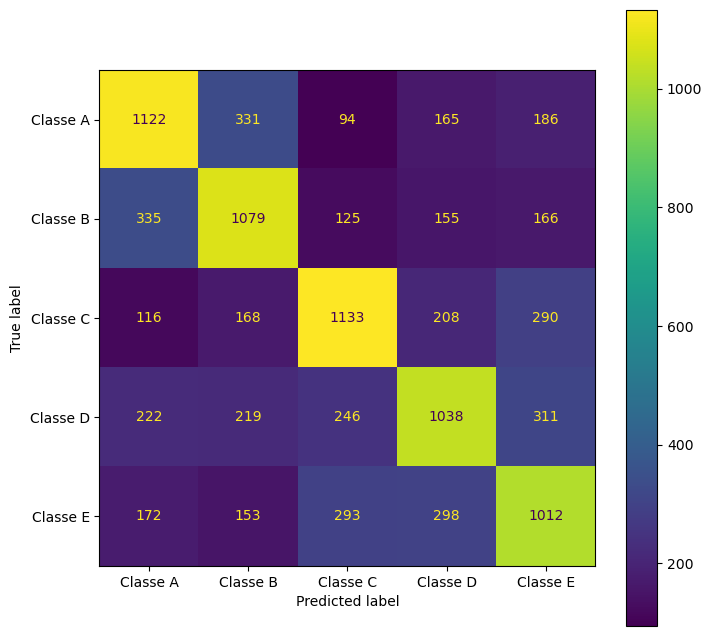

In [62]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_test, svc_y_pred, labels=['Classe A', 'Classe B', 'Classe C', 'Classe D', 'Classe E'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Classe A', 'Classe B', 'Classe C', 'Classe D', 'Classe E'])
disp.plot(ax=ax)
plt.show()



Dada a qualidade dos dados, o SVC em questão desempenhou um bom papel em classificar os experimentos em questão. Considerando que um modelo aleatório teria uma acurária de apenas 20.o%, o modelo foi capaz de ser acertivo em 55,87% dos casos.